# Lesson 2: Perceptrons

*Teachers:* Fares Schulz, Lina Campanella

In this course we will cover
1. A [quick introduction](#intro) on the principles of neural networks
2. An implementation for a [single neuron](#neuron) in Numpy and JAX.
3. An exercise on [multi-layer perceptron (MLP)](#mlp) through manual derivation.
4. An introduction on [using Pytorch](#pytorch) for defining networks
5. An exercise on [audio classification](#audio) using an MLP with Pytorch.

## Single Neuron

For the first parts of the tutorial, we will perform the simplest classification model possible in a neural network setting: a single neuron. Understanding how a single neuron works is fundamental to grasping how entire neural networks operate.

### The Mathematical Model

We can model this behavior mathematically. An artificial neuron receives multiple inputs $x_1, x_2, ..., x_N$, each representing a feature or signal. The neuron computes a weighted sum of these inputs and applies an activation function to produce an output:

$$
y=\phi(\sum_{i = 1}^{N}w_{i} \cdot x_{i} + b)
$$



Let's break down each component:

- **Inputs ($x_i$)**: These are the features or signals coming into the neuron
- **Weights ($w_i$)**: Each input has an associated weight that determines its importance. Positive weights strengthen the signal, while negative weights inhibit it
- **Bias ($b$)**: This shifts the activation threshold, allowing the neuron to fire even when inputs are small, or requiring stronger inputs to fire
- **Activation function ($\phi$)**: This determines whether the neuron "fires" based on the weighted sum

For a simple perceptron, we can use different activation function. It is important that when we stack layers our activation function is differentiable. 

### Building Blocks of Networks

As we will see later on, a neural network is simply composed of layers of these neurons connected together. Each layer performs a transformation on its inputs, and by stacking multiple layers, we can learn increasingly complex patterns and representations. However, everything starts with understanding this single computational unit.

Now let's implement a single neuron ourselves. We will do so using the binary cross-entropy loss function and gradient descent. 

In [200]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, random, jit
import jax

key = random.PRNGKey(42)

In [201]:
# Creating a new data set
n_obs = 100
epsilon = np.random.randn(n_obs) * 2

# Input
x_class_0_0 = np.linspace(0, 1.1, n_obs)
x_class_1_0 = np.linspace(0.5, 2, n_obs)

# Output 
x_class_0_1 = -3 * x_class_0_0**3 + 13 + epsilon
x_class_1_1 = 2 * x_class_1_0**3 + 2 + epsilon

X = np.vstack([
    np.stack([x_class_0_0, x_class_0_1], axis=1),
    np.stack([x_class_1_0, x_class_1_1], axis=1)
])
Y = np.concatenate([
    np.zeros_like(x_class_0_0),
    np.ones_like(x_class_1_0)
])


### Binary Cross-Entropy Loss

For binary classification, we will use **Binary Cross-Entropy (BCE)** loss, also known as log loss. The Loss function is calculated as follows:

For a single sample:
$$
\ell(y_i, \hat{y_i}) = -[y_i \log(\hat{y_i}) + (1-y_i) \log(1-\hat{y_i})]
$$

For a batch of $n$ samples:
$$
\mathcal{L}(Y, \hat{Y}) = -\frac{1}{N}\sum_{i=1}^{N}[y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]
$$

where:
- $y \in \{0, 1\}$ is the true label
- $\hat{y} \in [0, 1]$ is the predicted probability (output of sigmoid)

In [202]:
# The funtion for the predictions
def model(X, W, b):
    z = b + W[0]*X[:,0] + W[1]*X[:,1]
    return jax.nn.sigmoid(z)


# Binary cross-entropy loss function  
def binary_cross_entropy_loss(Y, Y_pred):
    loss = -jnp.mean(Y*jnp.log(Y_pred)+(1-Y)*jnp.log(1 - Y_pred))
    return loss

def loss_with_params(X, Y, W, b):
    Y_pred = model(X, W, b)
    return binary_cross_entropy_loss(Y, Y_pred)

@jit
def gradient_descent(X, Y, W, b, lr):
    grad_w, grad_b = grad(loss_with_params, argnums=[2, 3])(X, Y, W, b)
    W = W - lr * grad_w
    b = b - lr * grad_b
    loss = loss_with_params(X, Y, W, b)
    return W, b, loss

# Optimization with gradient descent using jax's grad
def train(key, X, Y, lr=0.05, n_iter=1000):
    k_0, k_1 = random.split(key, 2)
    W = random.normal(k_0, (2,))   # [w_0, w_1]
    b = random.normal(k_1, (1,))

    loss_history = []

    for i in range(n_iter):
        W, b, loss = gradient_descent(X, Y, W, b, lr)
        if i % 50 == 0:  # nicht bei jedem Schritt speichern (leichter)
            loss_history.append(float(loss))

    return W, b, loss_history


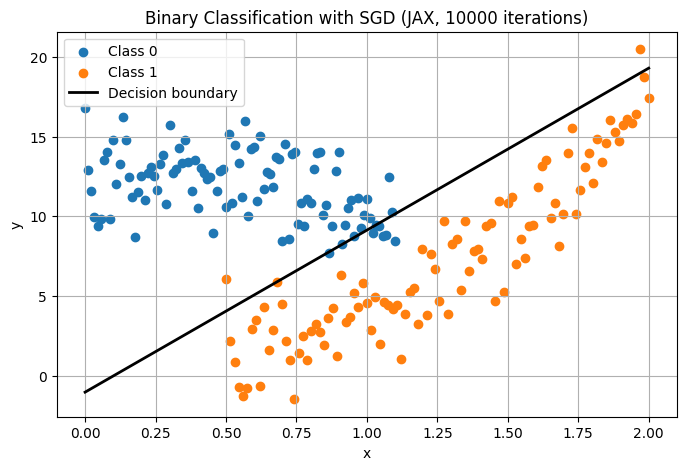

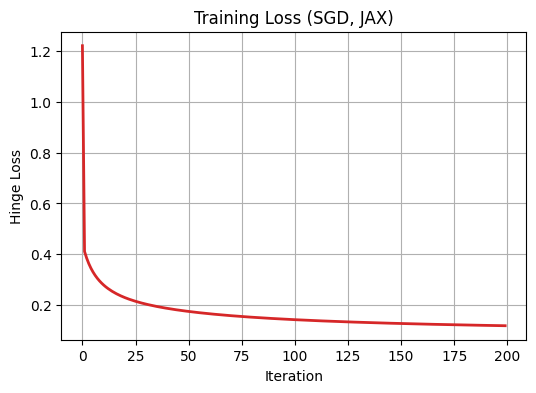

In [203]:
# Defining the number of iterations and learning rate
n_iters = 10000
lr = 0.03

W, b, loss_history = train(key, X, Y, lr, n_iters)

w_0, w_1 = W

x_line = jnp.linspace(X[:,0].min(), X[:,0].max(), 100)
y_line = -(b + w_0 * x_line) / w_1

# Plot data and fitted line
plt.figure(figsize=(8,5))
plt.scatter(x_class_0_0, x_class_0_1, color="C0", label="Class 0")
plt.scatter(x_class_1_0, x_class_1_1, color="C1", label="Class 1")
plt.plot(x_line, y_line, color="black", lw=2, label="Decision boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Binary Classification with SGD (JAX, {n_iters} iterations)")
plt.grid(True)
plt.legend()
plt.show()

# Plot loss over iterations
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")
plt.title("Training Loss (SGD, JAX)")
plt.grid(True)
plt.show()

## Multi-layer networks

### 2-layer XOR problem

In most cases, classification problems are far from being linear. Therefore, we need more advanced methods to be able to compute non-linear class boundaries. The advantage of neural networks is that the same principle can be applied in a layer-wise fashion. This allows to further discriminate the space in sub-regions. We will try to implement the 2-layer perceptron that can provide a solution to the infamous XOR problem. The idea is now to have the output of the first neurons to be connected to a set of other neurons.

### Backwardpropagation (Gradients via Chain Rule)

We will compute the gradients with backpropagation. The algorithm computes gradients efficiently by applying the chain rule from calculus. The chain rule tells us how to compute the derivative of a composed function.

If we have $\hat{y} = f(g(x))$, then:
$$
\frac{dy}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}
$$

In neural networks, we have many layers composed together, so we need to apply the chain rule repeatedly to compute how the loss changes with respect to each parameter.

The key insight is that we compute gradients backwards through the network:

1. **Output layer**: Compute $\delta^{(2)}$ using the loss gradient
2. **Output weights/biases**: Use $\delta^{(2)}$ and activations from previous layer
3. **Propagate backwards**: Pass $\delta^{(2)}$ through weights to get gradient at $\mathbf{h}_1$
4. **Hidden layer**: Compute $\delta^{(1)}$ by multiplying with sigmoid derivative
5. **Hidden weights/biases**: Use $\delta^{(1)}$ and the inputs

Each $\delta$ tells us "how much does the loss change if we change this pre-activation slightly?" and we use these to compute how to adjust the weights.

This is the **chain rule** in action: we're computing derivatives by multiplying local gradients as we move backwards through the computation graph!

A detailed explaination and a step by step calculation of the backpropagation can be found in the slides. Here we will show only the code to calculate the gradients with backpropagation.



In [204]:
np.random.seed(42)

X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
])
Y = np.array([[1], [0], [0], [1]])  # shape (4, 1)

In [205]:
def model(X, params):
    W_1, b_1, W_2, b_2 = params
    z_1 = (X @ W_1) + b_1
    h = sigmoid(z_1)  # Hidden layer activations
    z_2 = (h @ W_2) + b_2
    Y_pred = sigmoid(z_2)  # Output layer activations
    return h, Y_pred ## oder y_pred?

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(sigma):
    return sigma * (1 - sigma)

def binary_cross_entropy_loss(Y, Y_pred):
    eps = 1e-8 # so that there is no chance that log(0) which would give back an error
    return -np.mean(Y*np.log(Y_pred + eps) + (1 - Y)*np.log(1 - Y_pred + eps))

def binary_cross_entropy_loss_grad(Y, h, Y_pred, W_2, n_samples):

    # Step 1: Compute δ^(2) = ∂L/∂Z_2
    # Using chain rule: ∂L/∂Z_2 = ∂L/∂Y_pred * ∂Y_pred/∂Z_2
    # 
    # Where:
    #   ∂L/∂y_pred = -(Y/y_pred - (1-Y)/(1-y_pred))  [derivative of BCE]
    #   ∂y_pred/∂Z_2 = y_pred(1 - y_pred) 
    # Resulting in a very elegant function:  δ^(2) = y_pred - y
    delta_2 = Y_pred - Y

    # Step 2: Compute ∂L/∂W_2
    # Using chain rule: ∂L/∂W_2 = ∂L/∂Z_2 * ∂Z_2/∂W_2
    #
    # From forward pass: Z_2 = h @ W_2 + b_2
    # Therefore: ∂Z_2/∂W_2 = h
    #
    # So: ∂L/∂W_2 = δ^(2) @ h^T

    # Output layer weight gradient: ∂L/∂W^(L) = δ^(L) (h)^T
    dW_2 = (h.T @ delta_2) / n_samples
    
    # Step 3: Compute ∂L/∂b_2
    # Using chain rule: ∂L/∂b_2 = ∂L/∂Z_2 * ∂Z_2/∂b_2
    #
    # From forward pass: Z_2 = h @ W_2 + b_2
    # Therefore: ∂Z_2/∂b_2 = 1
    #
    # So: ∂L/∂b_2 = δ^(2) (summed over all samples)

    # Output layer bias gradient: ∂L/∂b^(L) = δ^(L)
    #db_2 = delta_2
    db_2 = np.mean(delta_2, axis=0, keepdims=True)

    # Hidden layer delta: δ^(L-1)
    dh_1 = np.dot(delta_2, W_2.T)
    delta_1 = dh_1 * sigmoid_derivative(h)
    
    # Hidden layer weight gradient: ∂L/∂W^(L-1) = δ^(L-1) (h^(L-2))^T
    # where h^(L-2) = X (the input)
    dW_1 = (X.T @ delta_1) / n_samples
    
    # Hidden layer bias gradient: ∂L/∂b^(L-1) = δ^(L-1)
    db_1 = np.mean(delta_1, axis=0, keepdims=True)
    
    return dW_2, db_2, dW_1, db_1

def train(X, Y, n_hidden=2, lr=0.1, n_iter=10000):
    n_samples, n_features = X.shape

    # Initialize weights
    W_1 = np.random.randn(n_features, n_hidden)
    b_1 = np.zeros((1, n_hidden))
    W_2 = np.random.randn(n_hidden, 1)
    b_2 = np.zeros((1, 1))

    params = (W_1, b_1, W_2, b_2)

    loss_history = []

    for i in range(n_iter):
        # Forward pass
        h, Y_pred = model(X, params)

        # Loss
        loss = binary_cross_entropy_loss(Y, Y_pred)
        loss_history.append(loss)

        
        dW_2, db_2, dW_1, db_1 = binary_cross_entropy_loss_grad(Y, h, Y_pred, W_2, n_samples)

        # Gradient update
        W_1 -= lr * dW_1
        b_1 -= lr * db_1
        W_2 -= lr * dW_2
        b_2 -= lr * db_2

    return W_1, b_1, W_2, b_2, Y_pred, loss_history

In [206]:
W_1, b_1, W_2, b_2, Y_pred, loss_history = train(X, Y, n_hidden=2, lr=0.5, n_iter=10000)
params = (W_1, b_1, W_2, b_2)

preds = (Y_pred > 0.5).astype(int)

print("Predictions:", preds.ravel())
print("True labels:", Y.ravel())

Predictions: [1 0 0 1]
True labels: [1 0 0 1]


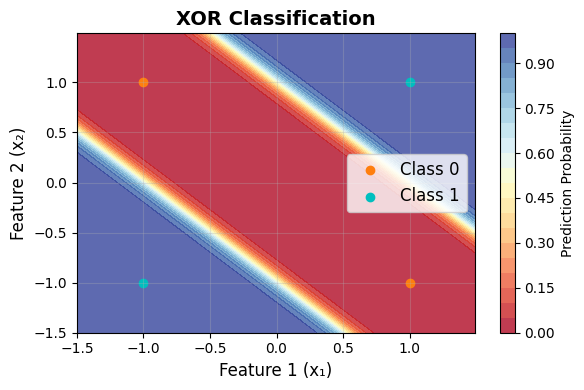

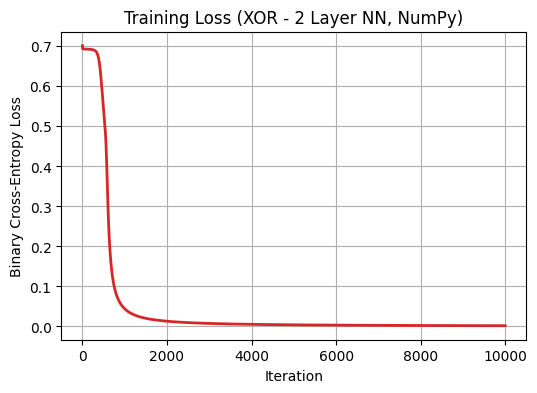

In [207]:
# Plot data
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

# Create input array from mesh grid
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Reshape predictions to match mesh grid
_, predictions = model(mesh_input, params) 

Z = predictions.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(6,4))

# Plot decision boundary and regions
contourf = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contourf, label='Prediction Probability')


# Plot decision boundary line (0.5 threshold)
#contour = plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
#plt.clabel(contour, inline=True)

class_0 = X[Y.ravel() == 0]
class_1 = X[Y.ravel() == 1]


plt.scatter(class_0[:, 0], class_0[:, 1], color="C1", label="Class 0")
plt.scatter(class_1[:, 0], class_1[:, 1], color="c", label="Class 1")

plt.xlabel('Feature 1 (x₁)', fontsize=12)
plt.ylabel('Feature 2 (x₂)', fontsize=12)
plt.title("XOR Classification", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss (XOR - 2 Layer NN, NumPy)")
plt.grid(True)
plt.show()

## XOR Problem with JAX

We will solve the same problem with JAX.

In [208]:
def model(X, params):
    W_1, b_1, W_2, b_2 = params
    z_1 = (X @ W_1) + b_1
    h = sigmoid(z_1)  # Hidden layer activations
    z_2 = (h @ W_2) + b_2
    Y_pred = sigmoid(z_2)  # Output layer activations
    return h, Y_pred ## oder y_pred?

def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

def sigmoid_derivative(sigma):
    return sigma * (1 - sigma)

def binary_cross_entropy_loss(Y, Y_pred):
    eps = 1e-8 # so that there is no chance that log(0) which would give back an error
    return -jnp.mean(Y*jnp.log(Y_pred + eps) + (1 - Y)*jnp.log(1 - Y_pred + eps))

def loss_with_params(X, Y, params):
    _,Y_pred = model(X, params)
    return binary_cross_entropy_loss(Y, Y_pred)

@jit
def gradient_descent(params, X, Y, lr):
    grads = grad(loss_with_params, argnums=2)(X, Y, params)
    new_params = tuple(p - lr * g for p, g in zip(params, grads))
    loss = loss_with_params(X, Y, new_params)
    return new_params, loss

def train(key, X, Y, n_hidden1=2, lr=0.5, n_iter=10000):
    n_samples, n_features = X.shape

    # Initialize weights
    k_0, k_1, k_2, k_3, k_4, k_5 = random.split(key, 6)
    W_1 = random.normal(k_0, (n_features, n_hidden1))
    b_1 = jnp.zeros((1, n_hidden1))
    W_2 = random.normal(k_2, (n_hidden1, 1))
    b_2 = jnp.zeros((1, 1))

    params = (W_1, b_1, W_2, b_2)

    loss_history = []

    # Training loop
    for i in range(n_iter):
        params, loss = gradient_descent(params, X, Y, lr)

        loss_history.append(float(loss))

    return params, loss_history

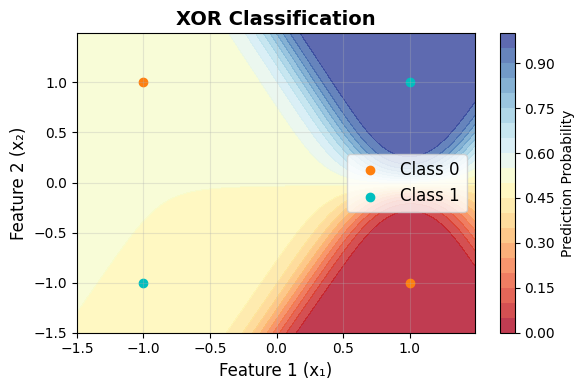

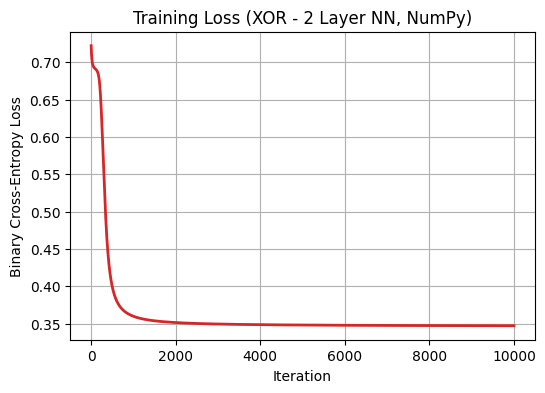

In [209]:
params, loss_history = train(key, X, Y, n_hidden1=2, lr=0.5, n_iter=10000)

# Plot data
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

# Create input array from mesh grid
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Reshape predictions to match mesh grid
_, predictions = model(mesh_input, params) 

Z = predictions.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(6,4))

# Plot decision boundary and regions
contourf = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contourf, label='Prediction Probability')


# Plot decision boundary line (0.5 threshold)
#contour = plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
#plt.clabel(contour, inline=True)

class_0 = X[Y.ravel() == 0]
class_1 = X[Y.ravel() == 1]


plt.scatter(class_0[:, 0], class_0[:, 1], color="C1", label="Class 0")
plt.scatter(class_1[:, 0], class_1[:, 1], color="c", label="Class 1")

plt.xlabel('Feature 1 (x₁)', fontsize=12)
plt.ylabel('Feature 2 (x₂)', fontsize=12)
plt.title("XOR Classification", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss (XOR - 2 Layer NN, NumPy)")
plt.grid(True)
plt.show()

## Implementation with JAX and two hidden layers

The prediction unfortunately is not optimal using only one hidden layer. We would expect that prot would be devided in squares, not a line. In the next exercise we will show how this is better approximated by a neural network with 2 hidden layers. Since we already showed how the chain rule works using numpy we will use JAX that already has

In [210]:
def model(X, params):
    W_1, b_1, W_2, b_2, W_3, b_3 = params
    z_1 = jnp.dot(X, W_1) + b_1
    h_1 = sigmoid(z_1)
    z_2 = jnp.dot(h_1, W_2) + b_2
    h_2 = sigmoid(z_2)
    z_3 = jnp.dot(h_2, W_3) + b_3
    y_pred = sigmoid(z_3)
    return h_1, h_2, y_pred

def sigmoid(z):
    return 1 / (1 + jnp.exp(-z))

def binary_cross_entropy_loss(Y, Y_pred):
    eps = 1e-8
    return -jnp.mean(Y * jnp.log(Y_pred + eps) + (1 - Y) * jnp.log(1 - Y_pred + eps))

def loss_with_params(X, Y, params):
    _,_,Y_pred = model(X, params)
    return binary_cross_entropy_loss(Y, Y_pred)


In [211]:
@jit
def gradient_descent(params, X, Y, lr):
    grads = grad(loss_with_params, argnums=2)(X, Y, params)
    new_params = tuple(p - lr * g for p, g in zip(params, grads))
    loss = loss_with_params(X, Y, new_params)
    return new_params, loss

def train(key, X, Y, n_hidden1=4, n_hidden2=4, lr=0.5, n_iter=10000):
    n_samples, n_features = X.shape

    # Initialize weights
    k_0, k_1, k_2, k_3, k_4, k_5 = random.split(key, 6)
    W_1 = random.normal(k_0, (n_features, n_hidden1))
    b_1 = jnp.zeros((1, n_hidden1))
    W_2 = random.normal(k_2, (n_hidden1, n_hidden2))
    b_2 = jnp.zeros((1, n_hidden2))
    W_3 = random.normal(k_4, (n_hidden2, 1))
    b_3 = jnp.zeros((1, 1))

    params = (W_1, b_1, W_2, b_2, W_3, b_3)

    loss_history = []

    # Training loop
    for i in range(n_iter):
        params, loss = gradient_descent(params, X, Y, lr)

        loss_history.append(float(loss))

    return params, loss_history


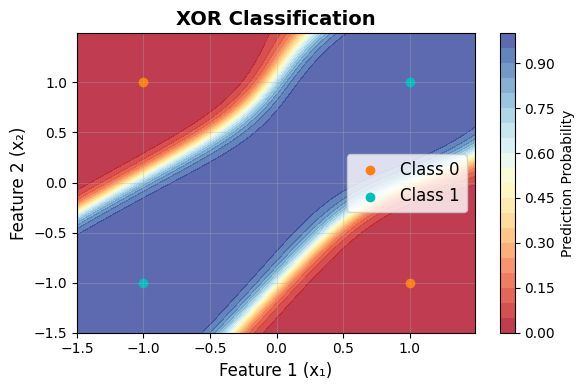

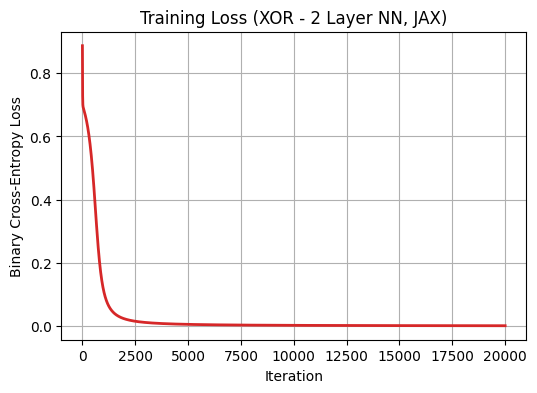

In [212]:
params, loss_history = train(key, X, Y, n_hidden1=7, n_hidden2=7, lr=0.08, n_iter=20000)

# Plot data and fitted line
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

# Create input array from mesh grid
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Reshape predictions to match mesh grid
_, _, predictions = model(mesh_input, params)

Z = predictions.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(6,4))

# Plot decision boundary and regions
contourf = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contourf, label='Prediction Probability')

class_0 = X[Y.ravel() == 0]
class_1 = X[Y.ravel() == 1]

plt.scatter(class_0[:, 0], class_0[:, 1], color="C1", label="Class 0")
plt.scatter(class_1[:, 0], class_1[:, 1], color="c", label="Class 1")

plt.xlabel('Feature 1 (x₁)', fontsize=12)
plt.ylabel('Feature 2 (x₂)', fontsize=12)
plt.title("XOR Classification", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss (XOR - 2 Layer NN, JAX)")
plt.grid(True)
plt.show()

# Pytorch

PyTorch is a powerful and flexible library designed for machine learning and deep learning research and development. It provides a tensor-based computation framework similar to NumPy, but with the added ability to perform automatic differentiation and to leverage GPU acceleration seamlessly.

It is built around the concept of dynamic computation graphs, which are created on the fly as operations are executed. This "define-by-run" paradigm makes PyTorch intuitive and flexible, allowing researchers to write and debug models in pure Python while still benefiting from high performance.

PyTorch is widely used for implementing neural networks, training deep learning models, and experimenting with new architectures in both academia and industry. It supports a large ecosystem of tools and libraries, including torchaudio for audio processing, and torchtext for natural language processing.

**Useful functions and modules:**
- `torch.tensor`: creates a tensor, the fundamental data structure in PyTorch. Tensors can track gradients when requires_grad=True. [Documentation](https://docs.pytorch.org/docs/stable/tensors.html)
- `torch.nn`: provides modules and classes for defining neural network layers, activation functions, and losses. [Documentation](https://docs.pytorch.org/docs/stable/nn.html)
- `torch.optim`: implements common optimization algorithms such as SGD and Adam for training models. [Documentation](https://docs.pytorch.org/docs/stable/optim.html)
- `loss.backward()`: automatically computes gradients of the loss with respect to model parameters.
- `torch.no_grad()`: disables gradient tracking, typically used during model evaluation to improve efficiency.

### Two hidden layers implemented in Pytorch

We will now solve the same XOR Problem with 2 layers using pytorch.

In [213]:
import torch
import torch.nn as nn
import torch.optim as optim

class XORNet(nn.Module):
    def __init__(self, n_input=2, n_hidden1=7, n_hidden2=7, n_output=1):
        super().__init__()
        self.layer1 = nn.Linear(n_input, n_hidden1)
        self.layer2 = nn.Linear(n_hidden1, n_hidden2)
        self.output = nn.Linear(n_hidden2, n_output)
        self.activation = nn.Sigmoid()
        
    def forward(self, X):
        z1 = self.activation(self.layer1(X))
        z2 = self.activation(self.layer2(z1))
        out = self.output(z2)  # logits (not softmaxed yet)
        return out

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

n_iters = 10000
lr = 0.5

loss_history = []

# Initialize model, loss, optimizer
model = XORNet()
criterion = nn.BCEWithLogitsLoss()  # combines sigmoid + binary cross-entropy

for epoch in range(n_iters):
    output = model(X)
    loss = criterion(output, Y)
    model.zero_grad()

    loss.backward()

    # optimization 
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    
    loss_history.append(loss.item())

with torch.no_grad():
    preds = torch.sigmoid(model(X))



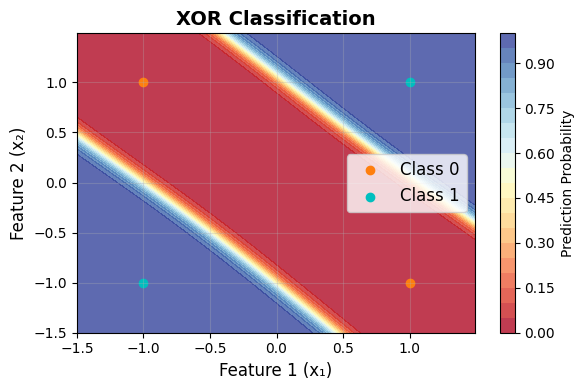

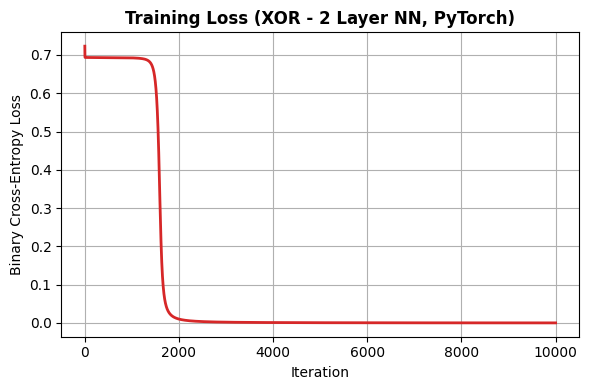

In [214]:
# Convert X and Y to NumPy for plotting
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

# Create a mesh grid over the input space
x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
h = 0.01  # step size in the mesh

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Prepare input grid for model prediction
mesh_input = np.c_[xx.ravel(), yy.ravel()]
mesh_tensor = torch.tensor(mesh_input, dtype=torch.float32)

# Get model predictions
with torch.no_grad():
    logits = model(mesh_tensor)
    preds = torch.sigmoid(logits).numpy()  # convert to probabilities

# Reshape predictions to match grid shape
Z = preds.reshape(xx.shape)


plt.figure(figsize=(6, 4))

# Plot decision surface
contourf = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contourf, label='Prediction Probability')

# Scatter plot of data points
class_0 = X_np[Y_np.ravel() == 0]
class_1 = X_np[Y_np.ravel() == 1]

plt.scatter(class_0[:, 0], class_0[:, 1], color="C1", label="Class 0")
plt.scatter(class_1[:, 0], class_1[:, 1], color="c", label="Class 1")

plt.xlabel('Feature 1 (x₁)', fontsize=12)
plt.ylabel('Feature 2 (x₂)', fontsize=12)
plt.title("XOR Classification", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.figure(figsize=(6, 4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss (XOR - 2 Layer NN, PyTorch)", fontsize=12, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


## Initializing the parameters

One way of optimizing the training is to start with certain initial values for the paramaters. Until now we always started with a random value. However there are other ways to initialize the weight with for example the Xavier Initialization. We will look at the Xavier initialization in the following exercize. We will do do the same as in the last exercise but with the Xavier initialization.

In [215]:
def xavier_init(key, shape):
    input, output = shape
    limit = jnp.sqrt(6.0 / (input + output))
    return random.uniform(key, shape, minval=-limit, maxval=limit)


def train_xavier_init(key, X, Y, n_hidden1=4, n_hidden2=4, lr=0.5, n_iter=10000):
    n_samples, n_features = X.shape

    # Initialize weights
    k_0, k_1, k_2, k_3, k_4, k_5 = random.split(key, 6)
    W_1 = xavier_init(k_1, (n_features, n_hidden1))
    b_1 = jnp.zeros((1, n_hidden1))
    W_2 = xavier_init(k_3, (n_hidden1, n_hidden2))
    b_2 = jnp.zeros((1, n_hidden2))
    W_3 = xavier_init(k_5, (n_hidden2, 1))
    b_3 = jnp.zeros((1, 1))

    params = (W_1, b_1, W_2, b_2, W_3, b_3)

    loss_history = []

    # Training loop
    for i in range(n_iter):
        params, loss = gradient_descent(params, X, Y, lr)

        loss_history.append(float(loss))

    return params, loss_history

In [216]:
params, loss_history = train_xavier_init(key, X, Y, n_hidden1=4, n_hidden2=4, lr=0.03, n_iter=20000)

# Plot data and fitted line
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01  # Step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

# Create input array from mesh grid
mesh_input = np.c_[xx.ravel(), yy.ravel()]

# Reshape predictions to match mesh grid
_, _, predictions = model(mesh_input, params)

Z = predictions.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(6,4))

# Plot decision boundary and regions
contourf = plt.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
plt.colorbar(contourf, label='Prediction Probability')


# Plot decision boundary line (0.5 threshold)
#contour = plt.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
#plt.clabel(contour, inline=True)

class_0 = X[Y.ravel() == 0]
class_1 = X[Y.ravel() == 1]


plt.scatter(class_0[:, 0], class_0[:, 1], color="C1", label="Class 0")
plt.scatter(class_1[:, 0], class_1[:, 1], color="c", label="Class 1")

plt.xlabel('Feature 1 (x₁)', fontsize=12)
plt.ylabel('Feature 2 (x₂)', fontsize=12)
plt.title("XOR Classification", fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()


plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss (XOR - 2 Layer NN, JAX)")
plt.grid(True)
plt.show()

TypeError: Cannot interpret 'torch.float32' as a data type

## Exercise: Classification model for multi class 

In the next exersize you will build you own neural network to make a multi class classification model. 

### Implementation in JAX

First try to make the model using JAX.

In [ ]:
# Data
n_classes = 3
n_points = 100
noise = 0.2
radius = [0.2, 0.7, 1.2]

X_list, Y_list = [], []

for i, r in enumerate(radius):
    theta = np.linspace(0, 2*np.pi, n_points)
    if r == 0:  # center dot
        X_i = np.random.randn(n_points, 2) * noise
    else:
        X_i = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
        X_i += np.random.randn(n_points, 2) * noise
    y_i = np.ones(n_points, dtype=int) * i
    X_list.append(X_i)
    Y_list.append(y_i)

X = np.concatenate(X_list)
Y = np.concatenate(Y_list)

# Hyperparameter
n_iter = 10000
lr = 0.05

In [ ]:
def softmax(z):
    """
    Compute the Softmax activation function.
    Inputs:
        z       : array of pre-activation values for the output layer (shape: N_samples, N_classes)
    Returns:
        a       : array of probabilities (shape: N_samples, N_classes)
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    return a

def forward_pass(params, X):
    """
    Compute the forward pass for a two-layer neural network.
    Inputs:
        params  : a tuple containing parameters (W_1, b_1, W_2, b_2)
        X       : array of input features (shape: N_samples, N_features)
    Returns:
        logits  : array of pre-softmax scores (shape: N_samples, N_classes)
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    return logits

def cross_entropy_loss(thetas, X, Y_true):
    """
    Compute the Categorical Cross-Entropy Loss.
    Inputs:
        params  : a tuple containing parameters [W_1, b_1, W_2, b_2]
        X       : array of input features (shape: N_samples, N_features)
        Y       : array of true target values (one-hot encoded, shape: N_samples, N_classes)
    Returns:
        loss    : float, mean cross-entropy loss
    """

    ######################
    # YOUR CODE GOES HERE
    ######################

    return loss

@jit
def update_params(params, grads, lr):
    """
    Update parameters using gradient descent.
    Inputs:
        params  : tuple with current parameters
        grads   : gradients of the loss with respect to params
        lr      : the learning rate
    Returns:
        new_params : updated parameters
    """
    ######################
    # YOUR CODE GOES HERE
    ######################
    
    return new_params


def train_nn(X, Y_true, n_iter, lr, loss_func):
    """
    Perform stochastic gradient descent for the neural network.
    Inputs:
        X          : array of observations
        Y_true     : array of true target values (one-hot encoded)
        n_iter     : number of iterations
        lr         : learning rate
        cross_entropy_loss  : cross entropy loss function to compute loss 
    Returns:
        params        : tuple of learned coefficients
        loss_history  : list of loss values per iteration
    """
    
        ######################
        # YOUR CODE GOES HERE
        ######################
        
    return params, loss_history

In [ ]:
# Plot the predicton

### Implementation with Pytorch

Now do the same using pytorch.

In [ ]:
# Transform the data to tensors for PyTorch
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)

In [ ]:
class MultiClassNet(nn.Module):
    def __init__(self, n_input=2, n_hidden=2, n_output=3):
        """
        Initializes the layers of the network.
        Inputs:
            n_input  : number of input features
            n_hidden : number of hidden units in the single hidden layer
            n_output : number of output classes
        """
        super().__init__()
        ######################
        # YOUR CODE GOES HERE
        ######################
        
    def forward(self, X):
        """
        Defines the forward pass logic.
        Inputs:
            X : Tensor of input features (N_samples, N_features)
        Returns:
            out : Tensor of raw logits (N_samples, N_classes)
        """
        ######################
        # YOUR CODE GOES HERE
        ######################
        return out
    
# Initialize model, loss, optimizer
######################
# YOUR CODE GOES HERE
######################

# Training loop with optimization
######################
# YOUR CODE GOES HERE
######################

In [ ]:
# Plot the predicton

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def make_spiral(key, n_points=300, n_classes=3):
    """
    Generates a 2D spiral dataset with `n_classes` classes.
    Returns:
        X: shape (n_points*n_classes, 2)
        Y: shape (n_points*n_classes,)
    """
    keys = random.split(key, n_classes)
    X_list, Y_list = [], []

    for j, k in enumerate(keys):
        r = jnp.linspace(0.0, 1, n_points)
        t = jnp.linspace(j * 4, (j + 1) * 4, n_points) + 0.2 * random.normal(k, (n_points,))
        x1 = r * jnp.sin(t * 2.5)
        x2 = r * jnp.cos(t * 2.5)
        X_list.append(jnp.stack([x1, x2], axis=1))
        Y_list.append(jnp.ones(n_points, dtype=int) * j)

    X = jnp.concatenate(X_list)
    Y = jnp.concatenate(Y_list)
    return X, Y

def make_blobs(key, n_points=300, n_classes=3, spread=0.5):
    keys = random.split(key, n_classes)
    centers = jnp.array([[0,0], [2,2], [-2,2]])  # manually placed
    X_list, Y_list = [], []
    for i, k in enumerate(keys):
        X_i = centers[i] + spread * random.normal(k, (n_points, 2))
        X_list.append(X_i)
        Y_list.append(jnp.ones(n_points, dtype=int) * i)
    X = jnp.concatenate(X_list)
    Y = jnp.concatenate(Y_list)
    return X, Y

np.random.seed(0)



# for j in range(n_classes):
#     r = np.linspace(0.0, 1, n_points)
#     t = np.linspace(j * 4, (j + 1) * 4, n_points) + noise * np.random.randn(n_points)
#     x1 = r * np.sin(t * 2.5)
#     x2 = r * np.cos(t * 2.5)
#     X_list.append(np.stack([x1, x2], axis=1))
#     Y_list.append(np.ones(n_points, dtype=int) * j)

# X = np.concatenate(X_list)
# Y = np.concatenate(Y_list)

# X = torch.tensor(X, dtype=torch.float32)
# Y = torch.tensor(Y, dtype=torch.long)

n_classes = 3
n_points = 100
noise = 0.2
radius = [0.2, 0.7, 1.2]

X_list, Y_list = [], []

for i, r in enumerate(radius):
    theta = np.linspace(0, 2*np.pi, n_points)
    if r == 0:  # center dot
        X_i = np.random.randn(n_points, 2) * noise
    else:
        X_i = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
        X_i += np.random.randn(n_points, 2) * noise
    y_i = np.ones(n_points, dtype=int) * i
    X_list.append(X_i)
    Y_list.append(y_i)

X = np.concatenate(X_list)
Y = np.concatenate(Y_list)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)


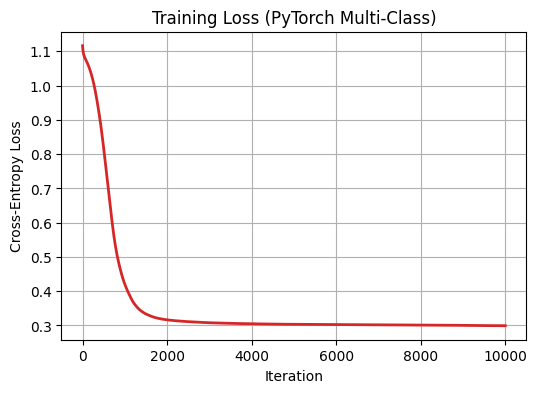

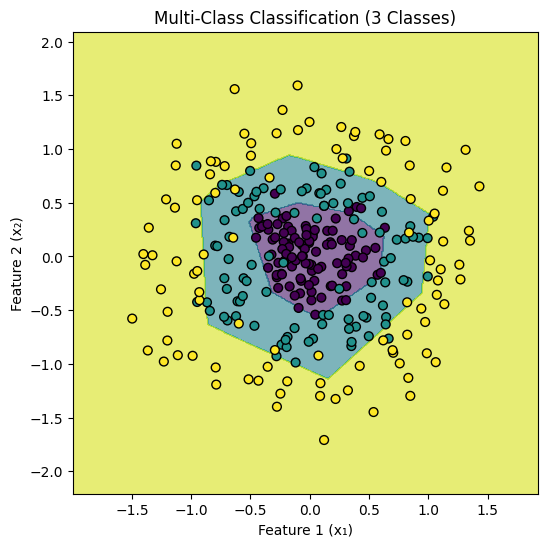

In [ ]:
# --- Define the model (in your old style: input → hidden → hidden → output)
class MultiClassNet(nn.Module):
    def __init__(self, n_input=2, n_hidden1=8, n_hidden2=8, n_output=3):
        super().__init__()
        self.layer1 = nn.Linear(n_input, n_hidden1)
        self.layer2 = nn.Linear(n_hidden1, n_hidden2)
        self.output = nn.Linear(n_hidden2, n_output)
        self.activation = nn.ReLU()
        
    def forward(self, X):
        z1 = self.activation(self.layer1(X))
        z2 = self.activation(self.layer2(z1))
        out = self.output(z2)  # logits (not softmaxed yet)
        return out

# --- 3️⃣  Initialize model, loss, optimizer
torch.manual_seed(0)
model = MultiClassNet()
criterion = nn.CrossEntropyLoss()  # for multi-class
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
n_iter = 10000
lr = 0.05

loss_history = []

for epoch in range(n_iter):
    logits = model(X)
    loss = criterion(logits, Y)

    model.zero_grad()
    
    loss.backward()

   
    # optimization 
    with torch.no_grad():
        for param in model.parameters():
            param -= lr * param.grad
    
    loss_history.append(loss.item())

# --- 5️⃣  Plot loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history, color="C3", lw=2)
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss (PyTorch Multi-Class)")
plt.grid(True)
plt.show()

# --- 6️⃣  Visualize decision boundaries
import numpy as np

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    logits = model(grid)
    probs = torch.softmax(logits, dim=1)
    Z = probs.argmax(dim=1).reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, alpha=0.6, cmap="viridis")
plt.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", edgecolor="k", s=40)
plt.title("Multi-Class Classification (3 Classes)")
plt.xlabel("Feature 1 (x₁)")
plt.ylabel("Feature 2 (x₂)")
plt.show()
